In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# v1
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

# v3
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.metrics import *
# v4

ACCURACY_LIST = []
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalMaxPooling2D
from keras.models import Model

# v5
#!pip install efficientnet
from efficientnet.keras import EfficientNetB4
from keras import backend as K

# v6
# Get reproducible results
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')

metadata.sample(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
4519,4519,person692_bacteria_2589.jpeg,Pnemonia,TRAIN,NaN,bacteria
3147,3147,person325_bacteria_1500.jpeg,Pnemonia,TRAIN,NaN,bacteria
3037,3037,person1945_bacteria_4872.jpeg,Pnemonia,TRAIN,NaN,bacteria
712,712,NORMAL2-IM-0490-0001.jpeg,Normal,TRAIN,NaN,NaN
5411,5434,NORMAL2-IM-0288-0001.jpeg,Normal,TEST,NaN,NaN
2126,2126,person1423_bacteria_3650.jpeg,Pnemonia,TRAIN,NaN,bacteria
5065,5065,person973_virus_1647.jpeg,Pnemonia,TRAIN,NaN,Virus
2639,2639,person1517_bacteria_3968.jpeg,Pnemonia,TRAIN,NaN,bacteria
3821,3821,person413_bacteria_1831.jpeg,Pnemonia,TRAIN,NaN,bacteria
416,416,IM-0616-0001.jpeg,Normal,TRAIN,NaN,NaN


In [3]:
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == metadata.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5675,5698,person112_bacteria_539.jpeg,Pnemonia,TEST,NaN,bacteria
5807,5830,person49_virus_101.jpeg,Pnemonia,TEST,NaN,Virus
5455,5478,NORMAL2-IM-0195-0001.jpeg,Normal,TEST,NaN,NaN
5609,5632,person134_bacteria_644.jpeg,Pnemonia,TEST,NaN,bacteria
5798,5821,person57_virus_113.jpeg,Pnemonia,TEST,NaN,Virus
5597,5620,person139_bacteria_661.jpeg,Pnemonia,TEST,NaN,bacteria
5895,5918,person1650_virus_2854.jpeg,Pnemonia,TEST,NaN,Virus
5671,5694,person113_bacteria_543.jpeg,Pnemonia,TEST,NaN,bacteria
5590,5613,person140_bacteria_668.jpeg,Pnemonia,TEST,NaN,bacteria
5869,5892,person1678_virus_2895.jpeg,Pnemonia,TEST,NaN,Virus


In [4]:
TEST_FOLDER = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
TRAIN_FOLDER = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

assert os.path.isdir(TEST_FOLDER) == True
assert os.path.isdir(TRAIN_FOLDER) == True

In [5]:
balanced_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]

balanced_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]

balanced_data_subset_normal = balanced_data[balanced_data['target'] == 'negative']
balanced_data_subset_covid = balanced_data[balanced_data['target'] == 'positive']
balanced_data_frac_normal = balanced_data_subset_normal.sample(frac=(1/5))

balanced_data_concat = pd.concat([balanced_data_frac_normal, balanced_data_subset_covid], axis=0)
balanced_data_concat = shuffle(balanced_data_concat, random_state=0)
balanced_data_train = balanced_data_concat[:240]
balanced_data_validation = balanced_data_concat[240:]

print(f"Balanced train data shape {balanced_data_train.shape}")
print(f"Balanced validation data shape {balanced_data_validation.shape}")

Balanced train data shape (240, 7)
Balanced validation data shape (86, 7)


In [6]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

balanced_train_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_train,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

balanced_validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_validation,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=TEST_FOLDER,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None
)

Found 240 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


## Base CNN model accuracy calculation

- The given 69 images divided into 4 classes will be trained on a simple 3 convolution layers CNN

In [19]:
#mempersiapkan fungsi callback
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.998):
                print("\nReached 95% accuracy so cancelling training!")
                self.model.stop_training = True

from tensorflow.keras.callbacks import LearningRateScheduler              
def scheduler(epoch):
    if epoch < 12:
      return 0.001
    else:
      print("Learning rate reduced to :", 0.001 * np.exp(0.5 * (5 - epoch)))
      return 0.001 * np.exp(0.5 * (5 - epoch))

custom_callback = LearningRateScheduler(scheduler)
    
callbacks = myCallback()

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

In [20]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# load the Xception network, ensuring the head FC layer sets are leftoff
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(name="avg_pool2d",pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu",name="first_dense")(headModel)
headModel = Dropout(0.5,name="dropout")(headModel)
headModel = Dense(2, activation="softmax",name="second_dense")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy','TruePositives','TrueNegatives','FalsePositives','FalseNegatives'])# Your Code Here)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [21]:
history = model.fit(x=balanced_train_generator,
                   validation_data=balanced_validation_generator,
                   epochs=50,
                   verbose=1,
                   callbacks=[callbacks, custom_callback])

Epoch 1/50
30/30 [==============================] - 26s 874ms/step - loss: 0.2735 - accuracy: 0.9042 - true_positives: 217.0000 - true_negatives: 217.0000 - false_positives: 23.0000 - false_negatives: 23.0000 - val_loss: 0.1763 - val_accuracy: 0.9302 - val_true_positives: 80.0000 - val_true_negatives: 80.0000 - val_false_positives: 6.0000 - val_false_negatives: 6.0000 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 22s 728ms/step - loss: 0.1841 - accuracy: 0.9417 - true_positives: 226.0000 - true_negatives: 226.0000 - false_positives: 14.0000 - false_negatives: 14.0000 - val_loss: 0.1460 - val_accuracy: 0.9651 - val_true_positives: 83.0000 - val_true_negatives: 83.0000 - val_false_positives: 3.0000 - val_false_negatives: 3.0000 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 28s 918ms/step - loss: 0.1266 - accuracy: 0.9625 - true_positives: 231.0000 - true_negatives: 231.0000 - false_positives: 9.0000 - false_negatives: 9.0000 - val_loss: 0.1106 - val_

30/30 [==============================] - 29s 962ms/step - loss: 0.0390 - accuracy: 0.9875 - true_positives: 237.0000 - true_negatives: 237.0000 - false_positives: 3.0000 - false_negatives: 3.0000 - val_loss: 0.3084 - val_accuracy: 0.9535 - val_true_positives: 82.0000 - val_true_negatives: 82.0000 - val_false_positives: 4.0000 - val_false_negatives: 4.0000 - lr: 5.5308e-07
Learning rate reduced to : 3.3546262790251187e-07
Epoch 22/50
30/30 [==============================] - 30s 991ms/step - loss: 0.1183 - accuracy: 0.9667 - true_positives: 232.0000 - true_negatives: 232.0000 - false_positives: 8.0000 - false_negatives: 8.0000 - val_loss: 0.2903 - val_accuracy: 0.9651 - val_true_positives: 83.0000 - val_true_negatives: 83.0000 - val_false_positives: 3.0000 - val_false_negatives: 3.0000 - lr: 3.3546e-07
Learning rate reduced to : 2.0346836901064418e-07
Epoch 23/50
30/30 [==============================] - 28s 943ms/step - loss: 0.0828 - accuracy: 0.9750 - true_positives: 234.0000 - true_ne

Learning rate reduced to : 4.1399377187851667e-11
Epoch 40/50
30/30 [==============================] - 32s 1s/step - loss: 0.1054 - accuracy: 0.9750 - true_positives: 234.0000 - true_negatives: 234.0000 - false_positives: 6.0000 - false_negatives: 6.0000 - val_loss: 0.1858 - val_accuracy: 0.9651 - val_true_positives: 83.0000 - val_true_negatives: 83.0000 - val_false_positives: 3.0000 - val_false_negatives: 3.0000 - lr: 4.1399e-11
Learning rate reduced to : 2.510999155743982e-11
Epoch 41/50
30/30 [==============================] - 28s 941ms/step - loss: 0.0423 - accuracy: 0.9792 - true_positives: 235.0000 - true_negatives: 235.0000 - false_positives: 5.0000 - false_negatives: 5.0000 - val_loss: 0.2566 - val_accuracy: 0.9535 - val_true_positives: 82.0000 - val_true_negatives: 82.0000 - val_false_positives: 4.0000 - val_false_negatives: 4.0000 - lr: 2.5110e-11
Learning rate reduced to : 1.522997974471263e-11
Epoch 42/50
30/30 [==============================] - 25s 841ms/step - loss: 0.081

In [22]:
model.save('model-balanced-50epochs.h5')

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("model-balanced-50epochs.tflite", "wb").write(tflite_quantized_model)

21070528

In [12]:
results = model.evaluate(balanced_validation_generator, batch_size=8, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1357


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(balanced_validation_generator, 86 // 8+1) #jmlah data di validation generator // batch size validation +1
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(balanced_validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['negative', 'positive']
print(classification_report(balanced_validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[52 13]
 [15  6]]
Classification Report
              precision    recall  f1-score   support

    negative       0.78      0.80      0.79        65
    positive       0.32      0.29      0.30        21

    accuracy                           0.67        86
   macro avg       0.55      0.54      0.54        86
weighted avg       0.66      0.67      0.67        86



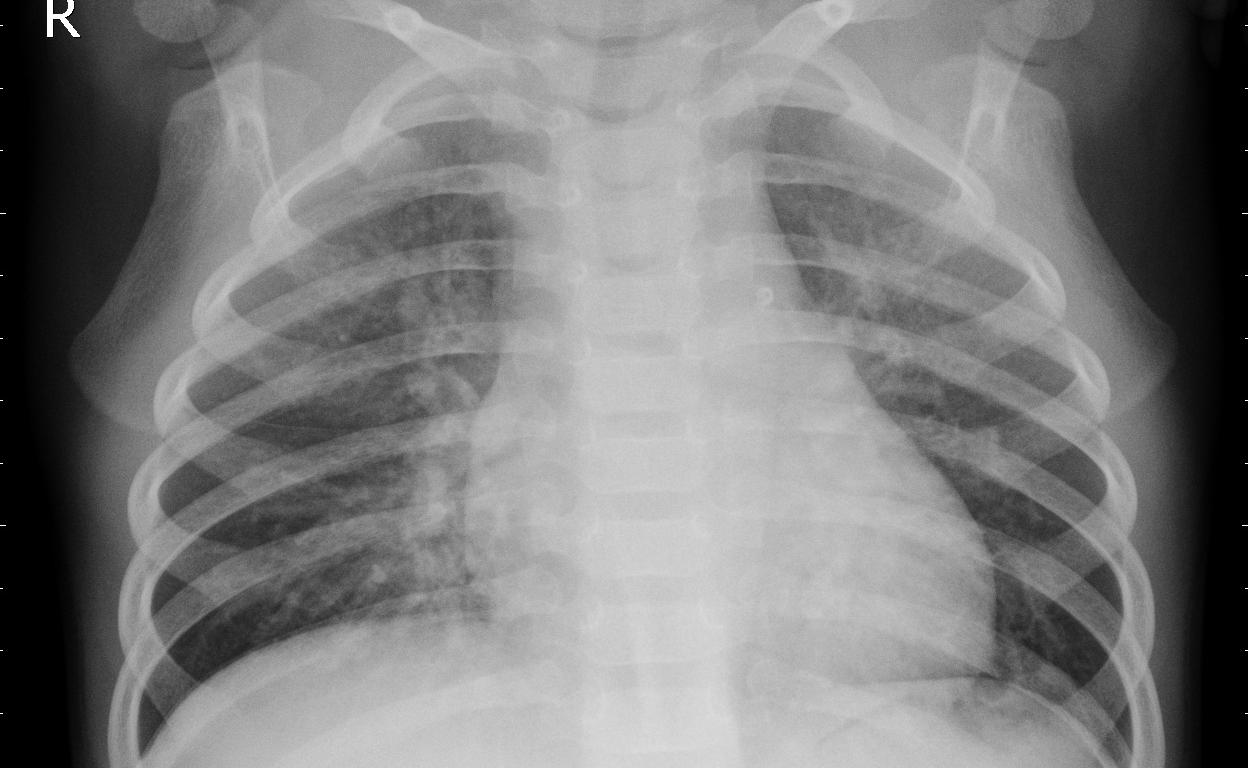

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = model
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool2d",
    "flatten",
    "first_dense",
    "dropout",
    "second_dense"
]

# The local path to our target image
img_path = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person1640_virus_2839.jpeg'

display(Image(img_path))


In [15]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

Predicted: [[9.9995804e-01 4.1960287e-05]]


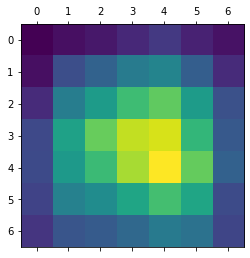

In [16]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

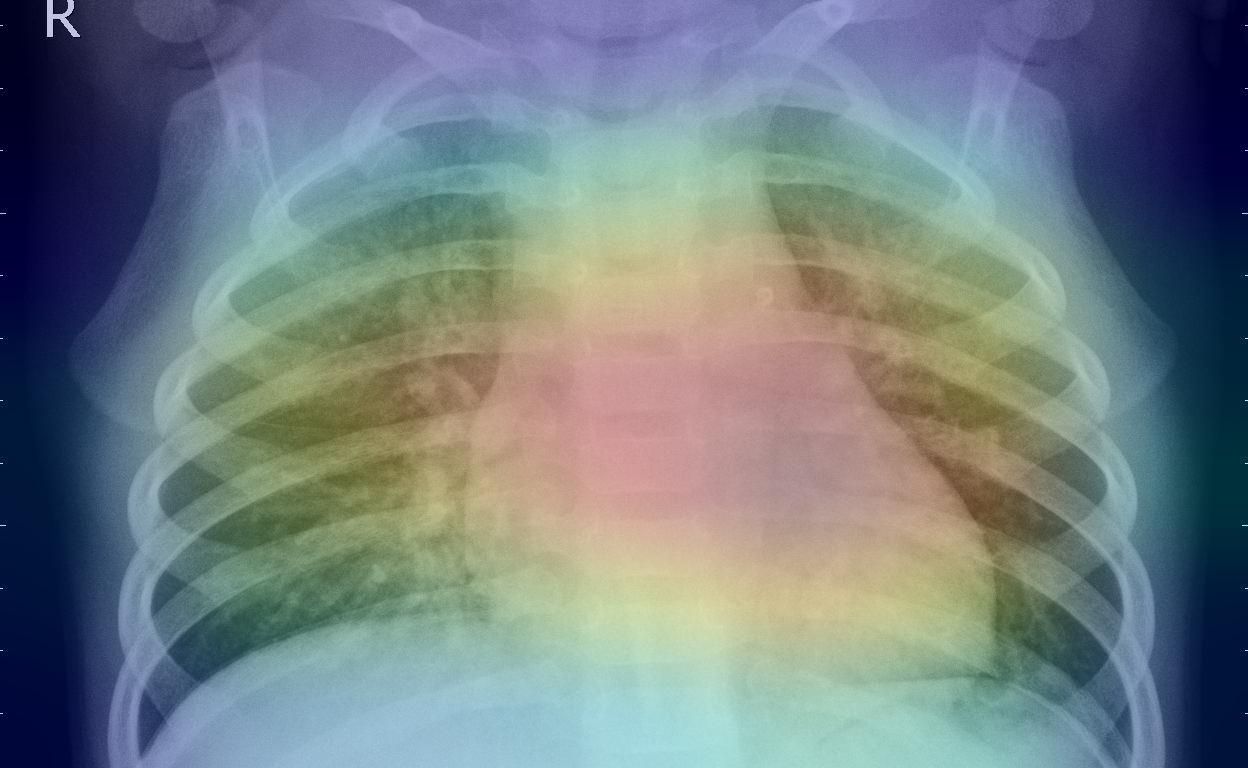

In [17]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.3 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "covid_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

In [ ]:
END
END
END
END
END
END
END
END
END
END
END
END
END
END
END
END
END
END


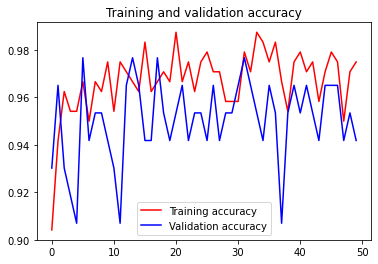

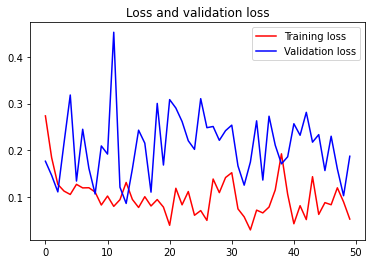

<Figure size 432x288 with 0 Axes>

In [25]:
#Grafik Akurasi
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
model.save('covid19_xray_base_cnn_model.h5')
ACCURACY_LIST.append(['Base CNN Model', history])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Base CNN model', size=16)
plt.show()

### Inference from base CNN model accuracy and AUC
- Base CNN model
    - Train data accuracy = 95.4 %
    - Validation data accuracy = 97 %


- Possible reasons for stale accuracy on 20 epochs
    - Highly imbalance target variables
        - COVID-19 target value = positive rows have count as 58
        - Normal target value = negative rows have count as 1342
        - `100 * (1342 / 1400) ~ 95.86 %`
        - Even if model classifies all the images as "Normal" label, it would achieve 95.86 % accuracy
        
- V5 Changes:
    - A good measure for imbalanced dataset is Area Under the Curve(AUC)
    - The metrics for the model changed to AUC in version 5
    - Comparision of models will be done based on AUC score

## Base CNN model with lower imbalance in data

- In this subsection, we try to remove 95.86 % imbalance present in the data
- We will remove 4 / 5 th of the Normal labelled images while keeping the count of COVID-19 labelled images same
- `1342 / 5 ~ 269; 269 / (269 + 58) ~ 82.26 % `
- To compensate for less number of training images, we increase the number of epochs

In [ ]:
balanced_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]

balanced_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]

balanced_data_subset_normal = balanced_data[balanced_data['target'] == 'negative']
balanced_data_subset_covid = balanced_data[balanced_data['target'] == 'positive']
balanced_data_frac_normal = balanced_data_subset_normal.sample(frac=(1/5))

balanced_data_concat = pd.concat([balanced_data_frac_normal, balanced_data_subset_covid], axis=0)
balanced_data_concat = shuffle(balanced_data_concat, random_state=0)
balanced_data_train = balanced_data_concat[:240]
balanced_data_validation = balanced_data_concat[240:]

print(f"Balanced train data shape {balanced_data_train.shape}")
print(f"Balanced validation data shape {balanced_data_validation.shape}")

In [ ]:
balanced_train_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_train,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

balanced_validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_validation,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

In [ ]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

balanced_model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

balanced_model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)

In [ ]:
balanced_model.summary()

In [ ]:
balanced_history = balanced_model.fit_generator(balanced_train_generator,
                                               epochs=30,
                                               validation_data=balanced_validation_generator,
                                               callbacks=[custom_callback])

In [ ]:
balanced_model.save('covid19_xray_base_cnn_model_balanced.h5')
ACCURACY_LIST.append(['Balanced Base Model', balanced_history])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Balanced base CNN model', size=16)
plt.show()

### Inferences

- Reducing imbalances results in reduced training images
- Accuracy reduced because of reduced training images
- Validation accuracy still remains stale even on reducing number of "Normal" labelled images
- V5 changes:
    - A good measure for imbalanced dataset is Area Under the Curve(AUC)
    - The metrics for the model changed to AUC in version 5
    - Comparision of models will be done based on AUC score

## Training ResNet 50 on data

[ResNet Introduction and Architecture](https://neurohive.io/en/popular-networks/resnet/)

In [ ]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

def output_custom_model(prebuilt_model):
    print(f"Processing {prebuilt_model}")
    prebuilt = prebuilt_model(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet')
    output = prebuilt.output
    output = GlobalMaxPooling2D()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=prebuilt.input, outputs=output)
    model.compile(optimizer='sgd', loss=binary_crossentropy,
              metrics=METRICS)
    return model

In [ ]:
resnet_custom_model = output_custom_model(ResNet50)
resnet_history = resnet_custom_model.fit_generator(train_generator,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

In [ ]:
resnet_custom_model.save('covid19_xray_resnet_50.h5')
ACCURACY_LIST.append(['ResNet 50', resnet_history])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('ResNet 50 model', size=16)
plt.show()

### Inference

- The effect of data imbalance is visible in validation accuracy measures
- Training accuracy of ResNet 50 is almost equal to base CNN model
- V5 Changes:
    - A good measure for imbalanced dataset is Area Under the Curve(AUC)
    - The metrics for the model changed to AUC in version 5
    - Comparision of models will be done based on AUC score

## Training EfficientNet B4 on data

[EfficientNet Arxiv Paper](https://arxiv.org/abs/1905.11946)

- Reduced batch-size of data generators due to ResourceExhaustionError()

In [ ]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

efficient_net_custom_model = output_custom_model(EfficientNetB4)
efficient_net_history = efficient_net_custom_model.fit_generator(train_generator,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

In [ ]:
efficient_net_custom_model.save('covid19_xray_efficient_net_B4.h5')
ACCURACY_LIST.append(['EfficientNet B4', efficient_net_history])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('EfficientNet B4 model', size=16)
plt.show()

## Binary Accuracy and AUC score comparision

- As the data is imbalanced, more concentration will be given on AUC score comparision

In [ ]:
ACCURACY_LIST = np.array(ACCURACY_LIST)
model_names = ACCURACY_LIST[:, 0]
histories = ACCURACY_LIST[:, 1]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('auc')[-1], histories)), ax=ax[0, 0], palette='Spectral')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_auc')[-1], histories)), ax=ax[0, 1], palette='gist_yarg')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('accuracy')[-1], histories)), ax=ax[1, 0], palette='rocket')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_accuracy')[-1], histories)), ax=ax[1, 1], palette='ocean_r')
ax[0, 0].set_title('Model Training AUC scores')
ax[0, 1].set_title('Model Validation AUC scores')
ax[1, 0].set_title('Model Training Accuracies')
ax[1, 1].set_title('Model Validation Accuracies')
fig.suptitle('Model Comparisions')
plt.show()

## TP, FP, TN, FN model comparisions

In [ ]:
metric_dataframe = pd.DataFrame({
    'Model Names': model_names,
    'True Positives': list(map(lambda x: x.history.get('tp')[-1], histories)),
    'False Positives': list(map(lambda x: x.history.get('fp')[-1], histories)),
    'True Negatives': list(map(lambda x: x.history.get('tn')[-1], histories)),
    'False Negatives': list(map(lambda x: x.history.get('fn')[-1], histories))
})
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x='Model Names', y='True Positives', data=metric_dataframe, ax=ax[0, 0], palette='BrBG')
sns.barplot(x='Model Names', y='False Positives', data=metric_dataframe, ax=ax[0, 1], palette='icefire_r')
sns.barplot(x='Model Names', y='True Negatives', data=metric_dataframe, ax=ax[1, 0], palette='PuBu_r')
sns.barplot(x='Model Names', y='False Negatives', data=metric_dataframe, ax=ax[1, 1], palette='YlOrBr')
ax[0, 0].set_title('True Positives of Models')
ax[0, 1].set_title('False Positives of Models')
ax[1, 0].set_title('True Negatives of Models')
ax[1, 1].set_title('False Negatives of Models')
fig.suptitle('Confusion Matrix comparision of Models', size=16)
plt.show()

### Inference from metric comparisions

- ResNet 50 has the most AUC score out of all the models
- In our experiment, it is higly important for a model to correctly predict COVID-19 patient, thus it should have high True Positive score and low False Negative score
- ResNet 50 has the highest True Positive score and lowest False Negative score
- From the metric comparisions, ResNet 50 model performs better than other models in the experiment